# Chapter 2: It's getting hot in here...
### Surface Air Temperature Anomalies

This tutorial walks you through analyzing and visualizing temperature data from the ERA5 reanalysis product reproducing main figures from the monthly <a href="https://climate.copernicus.eu/climate-bulletins">climate bulletins</a>.

### Getting ready

In [2]:
# Python Standard Libraries
import os  
import datetime as dt
from string import ascii_lowercase as ABC 

# Data Manipulation Libraries
import numpy as np 
import pandas as pd
import xarray as xr

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates 
import cartopy.crs as ccrs 

plt.style.use('copernicus.mplstyle')  # Set the visual style of the plots; not necessary for the tutorial

# Climate Data Store API for retrieving climate data
import cdsapi

Next, we set up the directory where we will download and store our data.

In [3]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(dir_loc, exist_ok=True) # create the folder if not available
filename = 'temperature_era5.nc'
path_to_file = os.path.join(dir_loc, filename)

Now, let's retrieve our data from the CDS using the `cdsapi.Client()`. Here, we download the reanalysis ERA5 single levels monthly means data for the variable '2m_temperature' from 1950 to 2022.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

In [5]:
c = cdsapi.Client()

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': '2m_temperature',
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    'grid': [1, 1]
  },
  path_to_file
)

2023-06-21 16:08:00,833 INFO Welcome to the CDS
2023-06-21 16:08:00,834 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-06-21 16:08:01,001 INFO Request is queued
2023-06-21 16:08:02,068 INFO Request is running
2023-06-21 16:12:19,615 INFO Request is completed
2023-06-21 16:12:19,616 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1687356725.7372034-17292-16-d6b3df82-f738-4e9f-b1d4-bd49b12319d1.nc to data/temperature.nc (108.9M)
2023-06-21 16:13:59,481 INFO Download rate 1.1M/s  


Result(content_length=114167064,content_type=application/x-netcdf,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1687356725.7372034-17292-16-d6b3df82-f738-4e9f-b1d4-bd49b12319d1.nc)

Once downloaded, we can load this data into an `xarray.DataArray`.

In [6]:
with xr.open_dataarray(path_to_file) as t2m:
  pass

In [51]:
file_berkeley = 'temperature_berkeley.nc'
path_to_berkely = os.path.join(dir_loc, file_berkeley)

c = cdsapi.Client()

c.retrieve(
    'insitu-gridded-observations-global-and-regional',
    {
        'format': 'zip',
        'origin': 'berkearth',
        'region': 'global',
        'variable': 'temperature_anomaly',
        'statistic': 'mean',
        'time_aggregation': 'monthly',
        'horizontal_aggregation': '1_x_1',
        'version': 'v1.0',
        'year': list(range(1750, 2020)),
    },
    path_to_berkely.replace('.nc', '.zip')  # not available for netcdf format
)

2023-06-21 16:42:27,780 INFO Welcome to the CDS
2023-06-21 16:42:27,782 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-global-and-regional
2023-06-21 16:42:27,929 INFO Request is completed
2023-06-21 16:42:27,929 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data2/dataset-insitu-gridded-observations-global-and-regional-4d35b8ab-487d-4db5-9f95-a4cfb5215333.zip to data/temperature_berkeley.zip (174.4M)
2023-06-21 16:44:14,396 INFO Download rate 1.6M/s  


Result(content_length=182886075,content_type=application/zip,location=https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data2/dataset-insitu-gridded-observations-global-and-regional-4d35b8ab-487d-4db5-9f95-a4cfb5215333.zip)

In [53]:
import zipfile

with zipfile.ZipFile(path_to_berkely.replace('.nc', '.zip'), 'r') as file:
        file.extractall(dir_loc) # unzip file
        # source_file = '200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc' # the name of the unzipped file
        # os.rename(f'{dir_loc}{source_file}', f'{dir_loc}satellites_{i_ghg}.nc') # rename to more intuitive name

## Visualising recent temperature anomalies

We calculate the climatology, i.e., the mean over a specific period, and anomalies (deviations from this mean). Here we use the time period 1991-2020 as a reference period in accordance with [current standards](https://climate.copernicus.eu/new-decade-brings-reference-period-change-climate-data). However, you may want to use the historical base period of 1961-1990 if you are particular interested in assessing changes due to climate change.

In [11]:
reference_period = slice('1991', '2020')
climatology = t2m.sel(time=reference_period).groupby('time.month').mean()
anomalies = t2m.groupby('time.month') - climatology

Next, we select a month of interest (`moi`) - let's go with March 2022.

In [14]:
moi = 3  # March (1 = January, 2 = February, etc.)

number2month = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

Plotting our data is a great way to visualize the temperature anomalies. We'll create maps showing the anomalies in three different regions: globally, Europe and the Arctic.

To start, three different types of map projections are specified, each for the corresponding region. The `EqualEarth()` projection is used for the global view, while `NearsidePerspective()` is used for the European and Arctic views. The central longitude and latitude are adjusted according to the region in focus. These projections help in providing an accurate spatial representation of the temperature anomalies.

In [15]:
SUBTITLES = ['Global', 'Europe', 'Arctic']
proj_maps = [
  ccrs.EqualEarth(),  # Global
  ccrs.NearsidePerspective(central_longitude=10, central_latitude=50),  # Europe
  ccrs.NearsidePerspective(central_longitude=0, central_latitude=90)  # Artic
]
proj_data = ccrs.PlateCarree()  # projection for the data

Next, a color normalization is established with the `Normalize()` function, which sets the range of temperature anomalies from -6 to 6. This ensures a consistent scale for interpreting the temperature anomaly maps across all three regions.

In [16]:
norm = mcolors.Normalize(vmin=-6, vmax=6)

Finally, we create a figure with three subplots dedicated for the three regions (`axes`), an axis for the colorbar (`cax`) and another for the title/subtitle (`tax`).

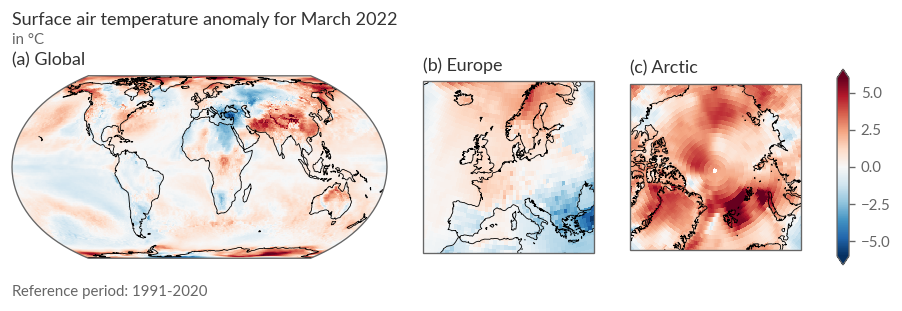

In [37]:
time = '2022-{0:02d}-01'.format(moi)

# Create the figure
fig = plt.figure(figsize=(9, 2.5), dpi=120)
gs = GridSpec(3, 4, figure=fig, width_ratios=[2.2, 1, 1, 0.07], height_ratios=[.05, 1, .05])

# Add the axes
tax = fig.add_subplot(gs[0, 0])
bax = fig.add_subplot(gs[2, 0])
axes = [fig.add_subplot(gs[1, i], projection=proj_maps[i]) for i in range(3)]
cax = fig.add_subplot(gs[1, 3])

# Set the extent of the maps
axes[1].set_extent([-15, 30, 33, 70], crs=proj_data)
axes[2].set_extent([-180, 180, 70, 90], crs=proj_data)

# Add coastlines and anomlies
for ax in axes:
  ax.coastlines(lw=0.5)
  anomalies.sel(time=time, drop=True).plot(
    ax=ax, transform=proj_data, cbar_ax=cax, norm=norm,
    cbar_kwargs=dict(label='')
  )

# Add titles, labels and text
for i, ax in enumerate(axes):
  ax.set_title(f'({ABC[i]}) {SUBTITLES[i]}')

title = f'Surface air temperature anomaly for {number2month[moi]} 2022'
tax.set_title(title)
tax.text(0, 0, 'in °C', ha='left', va='bottom', transform=tax.transAxes)
tax.axis('off')
bax.axis('off')
ref_start = reference_period.start
ref_end = reference_period.stop
bax.text(0, 0, f'Reference period: {ref_start}-{ref_end}', ha='left', va='bottom', transform=bax.transAxes)
fig.subplots_adjust(bottom=.0, hspace=0.02)
plt.show()

## Temperature anomalies over the last 70 years

To analyze long-term trends, we examine the weighted mean temperature anomalies over the past 70 years globally, in Europe and the Arctic regions.

The first step is to define the subregions we're interested in (Europe and the Arctic)

In [38]:
regions = {
    'europe': {'longitude': slice(-15, 30), 'latitude': slice(70, 30)},
    'arctic': {'longitude': slice(None, None), 'latitude': slice(None, 70)},
}

The second step is to to compute weights as the cosine of the latitude. These weights account for the spherical geometry of the Earth in our calculations. Since the Earth's surface area is greater at the equator than at the poles, the data points representing temperatures from different latitudes aren't equivalent. Weighting by the cosine of the latitude provides a way to adjust for this effect and treat the data more accurately.

In [39]:
weights = np.cos(np.deg2rad(t2m.latitude))
weights.name = 'weights'

We calculate the weighted mean temperature anomalies for each of our regions of interest. Each of these series of mean anomalies is smoothed using a rolling mean with a window size of 12 months to remove short-term fluctuations and highlight longer-term trends.

In [40]:
anom_mean_global = anomalies.weighted(weights).mean(('latitude', 'longitude'))
anom_mean_europe = anomalies.sel(regions['europe']).weighted(weights).mean(('latitude', 'longitude'))
anom_mean_arctic = anomalies.sel(regions['arctic']).weighted(weights).mean(('latitude', 'longitude'))

anom_mean_global = anom_mean_global.rolling(time=12, center=True).mean()
anom_mean_europe = anom_mean_europe.rolling(time=12, center=True).mean()
anom_mean_arctic = anom_mean_arctic.rolling(time=12, center=True).mean()

In addtion, let's have a look at the mean anomalies for a our month of interest (March) across years. Using the `sel` function, we extract data for the specific month from each of the rolling mean anomaly time series.

In [41]:
is_moi = anom_mean_global.time.dt.month == moi

anom_mean_moi_global = anom_mean_global.sel(time=is_moi)
anom_mean_moi_europe = anom_mean_europe.sel(time=is_moi)
anom_mean_moi_arctic = anom_mean_arctic.sel(time=is_moi)

And finally, let's visualize these long-term trends. We want to produce a bar plot with positive anomalies colored in red and negative anomalies colored in blue.

In [42]:
clrs_cool_warm = sns.color_palette('RdBu_r', as_cmap=False)
blue, red = clrs_cool_warm[0], clrs_cool_warm[-1]

colors_global = [red if anom >=0 else blue for anom in anom_mean_global]
colors_europe = [red if anom >=0 else blue for anom in anom_mean_europe]
colors_arctic = [red if anom >=0 else blue for anom in anom_mean_arctic]

We must take care of the proper bar width ourselves which depends on the number of days within a given month.

In [43]:
bar_width = pd.to_datetime(anom_mean_global.time.values).days_in_month
bar_width = [dt.timedelta(days=i) for i in bar_width]
bar_width_moi = dt.timedelta(days=31) 

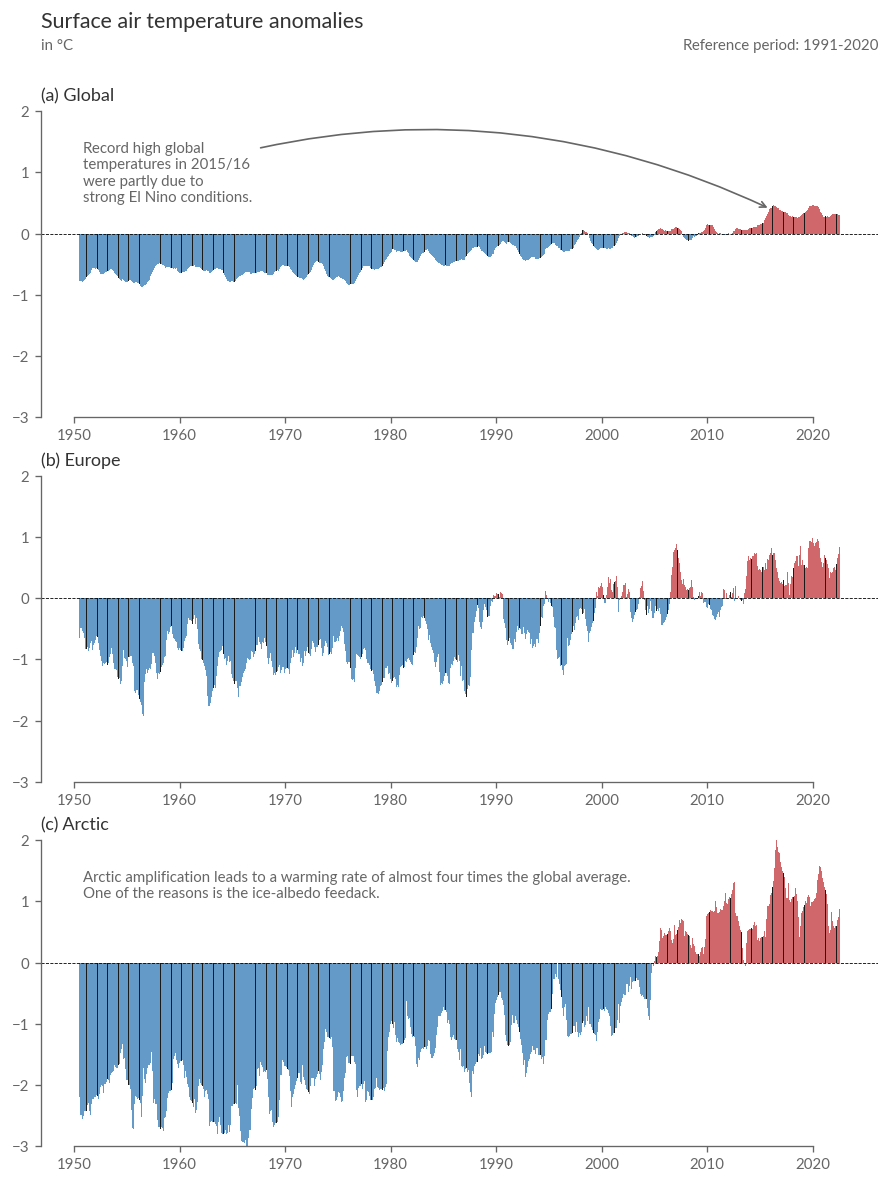

In [49]:
fig = plt.figure(figsize=(9, 12), dpi=120)
gs = GridSpec(4, 1, figure=fig, height_ratios=[.05, 1, 1, 1], hspace=0.25)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 4)]

axes[0].bar(pd.to_datetime(anom_mean_global.time), anom_mean_global.values, width=bar_width, color=colors_global, alpha=.75, align='edge')
axes[1].bar(pd.to_datetime(anom_mean_europe.time), anom_mean_europe.values, width=bar_width, color=colors_europe, alpha=.75, align='edge')
axes[2].bar(pd.to_datetime(anom_mean_arctic.time), anom_mean_arctic.values, width=bar_width, color=colors_arctic, alpha=.75, align='edge')

axes[0].bar(pd.to_datetime(anom_mean_moi_global.time), anom_mean_moi_global.values, width=bar_width_moi, color='.1', align='edge')
axes[1].bar(pd.to_datetime(anom_mean_moi_europe.time), anom_mean_moi_europe.values, width=bar_width_moi, color='.1', align='edge')
axes[2].bar(pd.to_datetime(anom_mean_moi_arctic.time), anom_mean_moi_arctic.values, width=bar_width_moi, color='.1', align='edge')

# Add annotations describing the data
desc_global = 'Record high global \ntemperatures in 2015/16 \nwere partly due to \nstrong El Nino conditions.'
desc_artic = 'Arctic amplification leads to a warming rate of almost four times the global average.\nOne of the reasons is the ice-albedo feedack.'
axes[0].annotate(
  desc_global,
  xy=(dt.datetime(2016, 1, 1), 0.4),
  xytext=(0.05, 0.9),
  textcoords=axes[0].transAxes,
  ha='left', va='top',
  arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
)
axes[2].text(0.05, 0.9, desc_artic, transform=axes[2].transAxes, ha='left', va='top')


for i, ax in enumerate(axes):
  ax.set_ylim(-3, 2)
  ax.axhline(0, color='k', ls='--', lw=0.5)
  ax.set_title(f'({ABC[i]}) {SUBTITLES[i]}')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
tax.axis('off')
tax.set_title('Surface air temperature anomalies', fontsize='x-large')
tax.text(0, 0, 'in °C', ha='left', va='bottom', transform=tax.transAxes)
tax.text(1, 0, f'Reference period: {ref_start}-{ref_end}', ha='right', va='bottom', transform=tax.transAxes)

sns.despine(fig, trim=True)

In conclusion, by analyzing and visualizing this temperature data, we can see the stark reality of rising temperatures - an irrefutable indicator of global warming.

### References

[1] Rantanen, M., Karpechko, A.Y., Lipponen, A. et al. The Arctic has warmed nearly four times faster than the globe since 1979. Commun Earth Environ 3, 168 (2022). https://doi.org/10.1038/s43247-022-00498-3